In [165]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import sklearn.metrics
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

### Importation et affichage des images

In [200]:
train_images = np.load("train_images.npy")
train_labels = np.load("train_labels.npy")
test_images = np.load("test_images.npy")
test_labels = np.load("test_labels.npy")

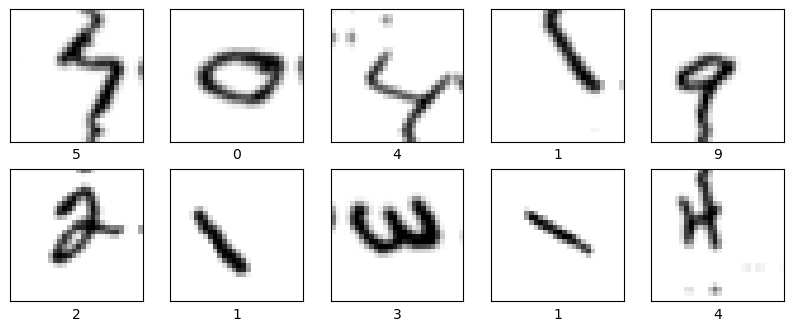

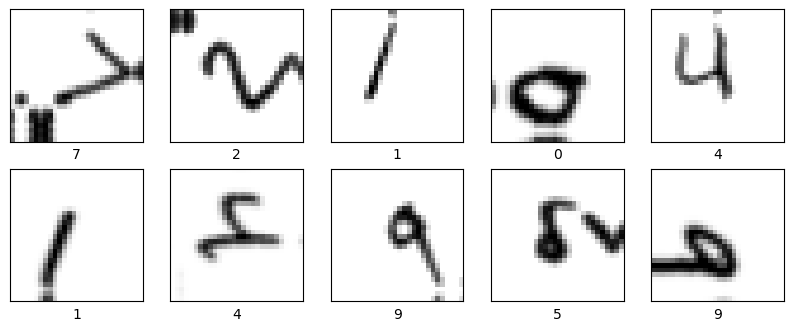

In [204]:
plt.figure(figsize=[10,10])
for i in range (10):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(train_labels[i])

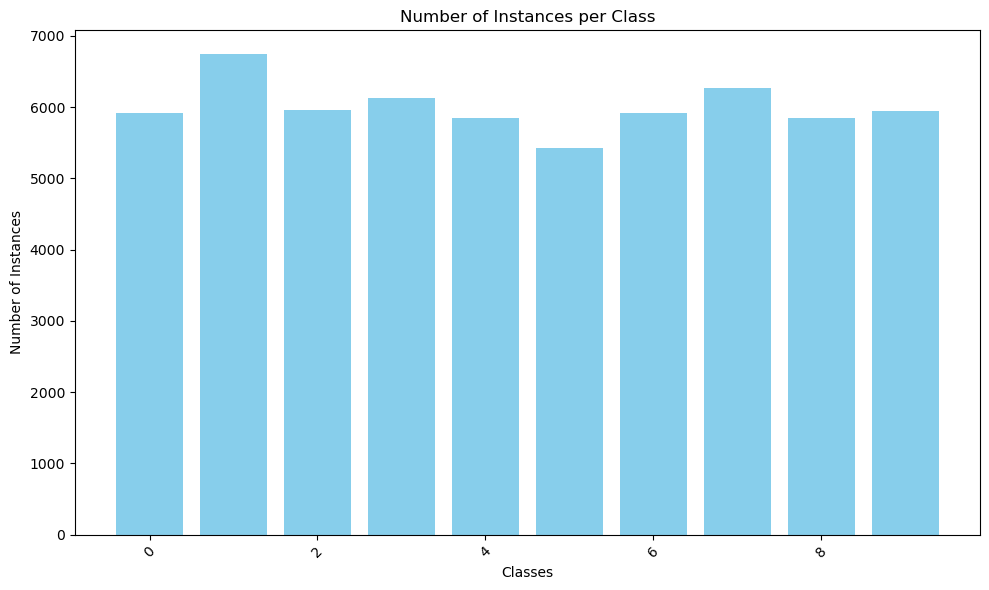

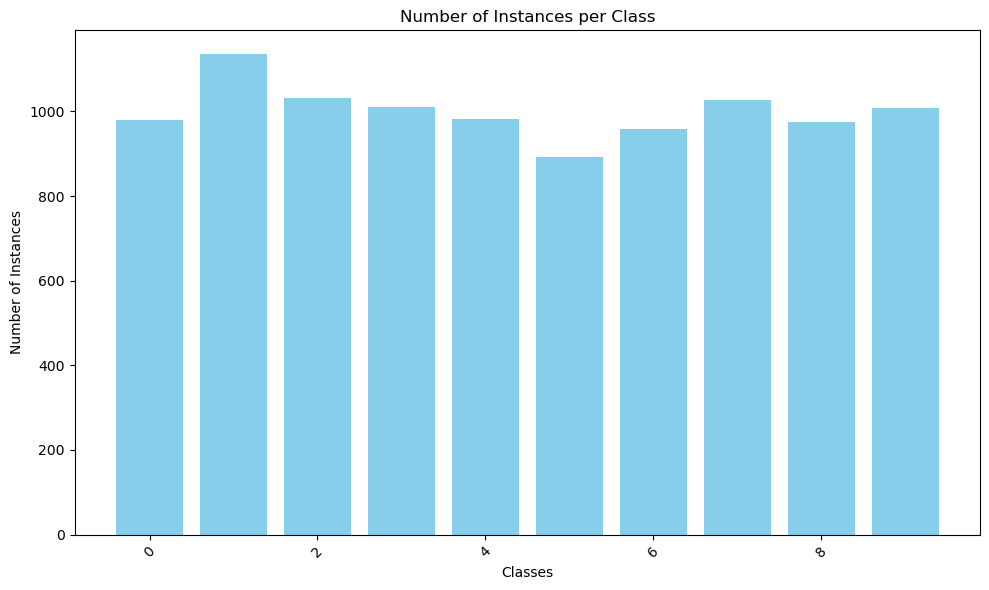

In [206]:
class_counts = pd.Series(train_labels).value_counts()

# Create a bar graph using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.title('Number of Instances per Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

class_counts_test = pd.Series(test_labels).value_counts()

# Create a bar graph using matplotlib
plt.figure(figsize=(10, 6))
plt.bar(class_counts_test.index, class_counts_test.values, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.title('Number of Instances per Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Apprentissage en couche dense

#### Création des vecteurs de pixel des images

In [202]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

num_pixels = train_images.shape[1] * train_images.shape[2] #784
train_images_flat = train_images.reshape(train_images.shape[0], num_pixels)
test_images_flat = test_images.reshape(test_images.shape[0], num_pixels)
print(train_images_flat.shape)
print(test_images_flat.shape)

(60000, 784)
(10000, 784)


#### Transformation des labels en format one hot

In [196]:
num_classes = 10
train_labels_oh = keras.utils.to_categorical(train_labels, num_classes)
test_labels_oh = keras.utils.to_categorical(test_labels, num_classes)

#### Mélange des données d'entrainement

In [197]:
ns =  train_images.shape[0] #number of examples
np.random.seed()
shuffle_index = np.random.permutation(ns)
train_images, train_images_flat, train_labels_oh = train_images[shuffle_index,:], train_images_flat[shuffle_index,:], train_labels_oh[shuffle_index,]


#### Création du model

In [190]:
optimizer = RMSprop(learning_rate=0.003)
callback = EarlyStopping(monitor="val_accuracy", patience = 5, restore_best_weights = True)

In [172]:
model = Sequential()
model.add(Dense(256, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
model.add(Dropout(.3))
model.add(Dense(128, kernel_initializer='normal', activation='relu'))
model.add(Dropout(.3))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_109 (Dense)           (None, 256)               200960    
                                                                 
 dropout_96 (Dropout)        (None, 256)               0         
                                                                 
 dense_110 (Dense)           (None, 128)               32896     
                                                                 
 dropout_97 (Dropout)        (None, 128)               0         
                                                                 
 dense_111 (Dense)           (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


#### Apprentissage

In [133]:
history = model.fit(train_images_flat, train_labels_oh, validation_split=0.2, epochs=30, batch_size=128, callback = [callback])
#
scores = model.evaluate(test_images_flat, test_labels_oh)
print("Neural network accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/30
375/375 [==============================] - 5s 9ms/step - loss: 2.0288 - accuracy: 0.2775 - val_loss: 1.6897 - val_accuracy: 0.4387
Epoch 2/30
375/375 [==============================] - 2s 7ms/step - loss: 1.6089 - accuracy: 0.4507 - val_loss: 1.3628 - val_accuracy: 0.5698
Epoch 3/30
375/375 [==============================] - 3s 7ms/step - loss: 1.3929 - accuracy: 0.5284 - val_loss: 1.2013 - val_accuracy: 0.6087
Epoch 4/30
375/375 [==============================] - 3s 7ms/step - loss: 1.2615 - accuracy: 0.5787 - val_loss: 1.0519 - val_accuracy: 0.6727
Epoch 5/30
375/375 [==============================] - 3s 7ms/step - loss: 1.1730 - accuracy: 0.6080 - val_loss: 0.9590 - val_accuracy: 0.7039
Epoch 6/30
375/375 [==============================] - 2s 7ms/step - loss: 1.1047 - accuracy: 0.6346 - val_loss: 0.9136 - val_accuracy: 0.7166
Epoch 7/30
375/375 [==============================] - 3s 7ms/step - loss: 1.0492 - accuracy: 0.6553 - val_loss: 0.8748 - val_accuracy: 0.7337
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


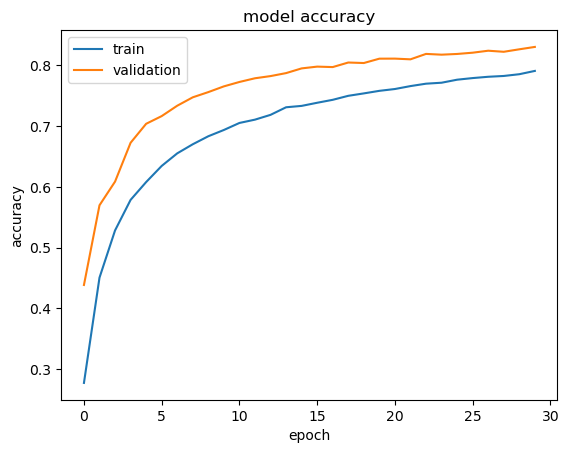

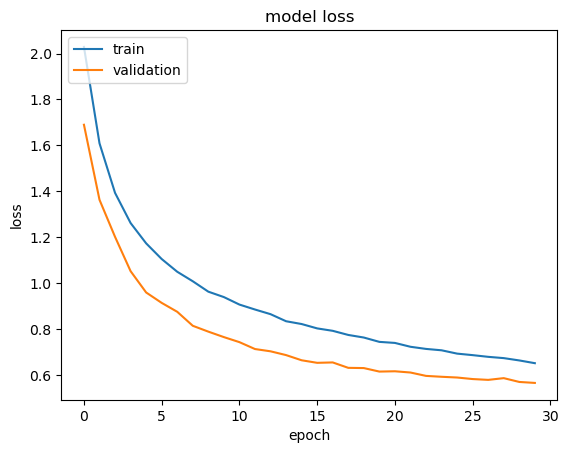

In [136]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [134]:
y_pred = model.predict(test_images_flat)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_pred_classes

313/313 [==============================] - 1s 2ms/step


array([7, 2, 1, ..., 4, 6, 6])

<Axes: >

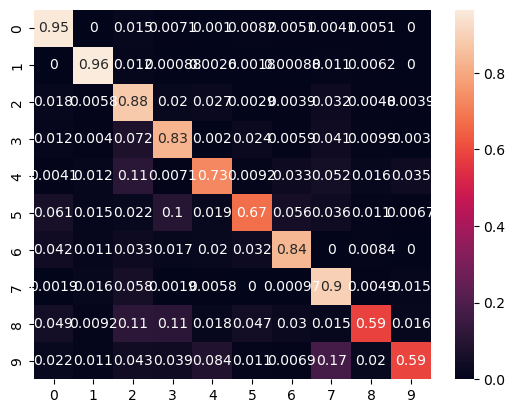

In [135]:
sns.heatmap(sklearn.metrics.confusion_matrix(test_labels, y_pred_classes, normalize="true"), annot=True)

#### Ajout de couches

In [113]:
optimizer = RMSprop(learning_rate=0.0005)
model2 = Sequential()
model2.add(Dense(256, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(128, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(128, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(128, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(128, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(128, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(128, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.3))
model2.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 256)               200960    
                                                                 
 dropout_64 (Dropout)        (None, 256)               0         
                                                                 
 dense_85 (Dense)            (None, 128)               32896     
                                                                 
 dropout_65 (Dropout)        (None, 128)               0         
                                                                 
 dense_86 (Dense)            (None, 128)               16512     
                                                                 
 dropout_66 (Dropout)        (None, 128)               0         
                                                                 
 dense_87 (Dense)            (None, 128)             

In [114]:
history = model2.fit(train_images_flat, train_labels_oh, validation_split=0.2, epochs=50, batch_size=128, callback = [callback])
#
scores = model2.evaluate(test_images_flat, test_labels_oh)
print("Neural network accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/50
375/375 [==============================] - 6s 13ms/step - loss: 2.1527 - accuracy: 0.1947 - val_loss: 2.0675 - val_accuracy: 0.2209
Epoch 2/50
375/375 [==============================] - 5s 12ms/step - loss: 1.9468 - accuracy: 0.2645 - val_loss: 1.8049 - val_accuracy: 0.3055
Epoch 3/50
375/375 [==============================] - 4s 12ms/step - loss: 1.8159 - accuracy: 0.3185 - val_loss: 1.6986 - val_accuracy: 0.3674
Epoch 4/50
375/375 [==============================] - 5s 12ms/step - loss: 1.6828 - accuracy: 0.3894 - val_loss: 1.4574 - val_accuracy: 0.4778
Epoch 5/50
375/375 [==============================] - 5s 14ms/step - loss: 1.5588 - accuracy: 0.4455 - val_loss: 1.3672 - val_accuracy: 0.5213
Epoch 6/50
375/375 [==============================] - 5s 12ms/step - loss: 1.4622 - accuracy: 0.4826 - val_loss: 1.2359 - val_accuracy: 0.5893
Epoch 7/50
375/375 [==============================] - 5s 13ms/step - loss: 1.3814 - accuracy: 0.5187 - val_loss: 1.1511 - val_accuracy: 0.6087

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


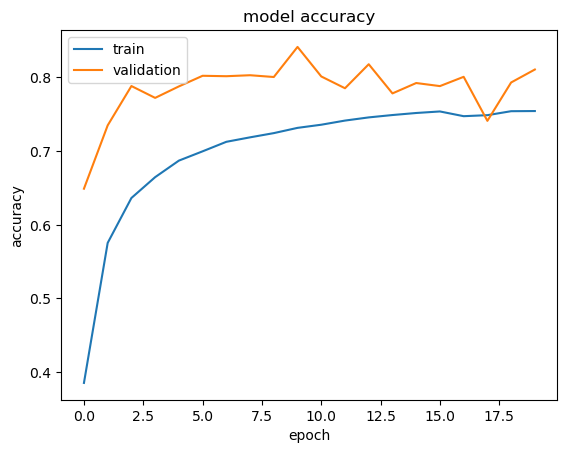

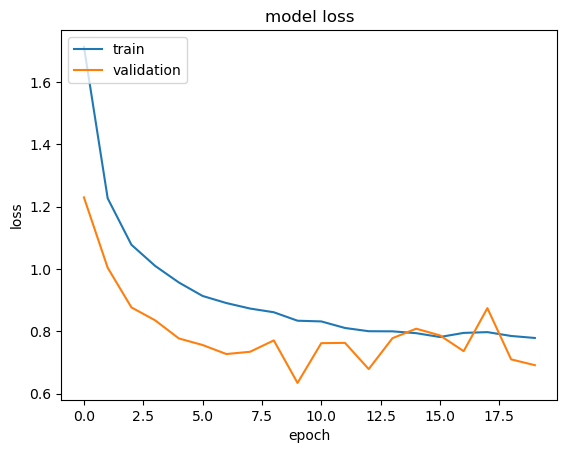

In [207]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [156]:
y_pred = model2.predict(test_images_flat)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_pred_classes

313/313 [==============================] - 1s 3ms/step


array([7, 2, 1, ..., 4, 5, 6])

<Axes: >

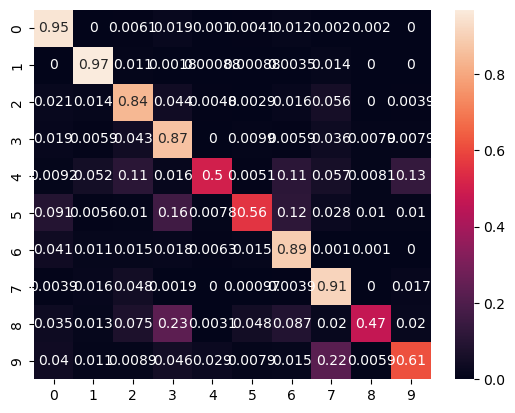

In [157]:
sns.heatmap(sklearn.metrics.confusion_matrix(test_labels, y_pred_classes, normalize="true"), annot=True)

### Apprentissage en couche convolutionnelle

In [198]:
optimizer = RMSprop(learning_rate=0.01)
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='normal', input_shape=(28, 28, 1)))
model_cnn.add(Dropout(.3))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='normal', input_shape=(28, 28, 1)))
model_cnn.add(Dropout(.3))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu', kernel_initializer='normal'))
model_cnn.add(Dropout(.3))
model_cnn.add(Dense(10, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
model_cnn.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 dropout_110 (Dropout)       (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 dropout_111 (Dropout)       (None, 11, 11, 32)        0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                

In [199]:
history = model_cnn.fit(train_images, train_labels_oh, validation_split = 0.2, epochs=20, batch_size=100)

Epoch 1/20
480/480 [==============================] - 38s 76ms/step - loss: 1.7129 - accuracy: 0.3854 - val_loss: 1.2298 - val_accuracy: 0.6490
Epoch 2/20
480/480 [==============================] - 37s 76ms/step - loss: 1.2268 - accuracy: 0.5754 - val_loss: 1.0039 - val_accuracy: 0.7349
Epoch 3/20
480/480 [==============================] - 37s 77ms/step - loss: 1.0777 - accuracy: 0.6364 - val_loss: 0.8766 - val_accuracy: 0.7883
Epoch 4/20
480/480 [==============================] - 37s 76ms/step - loss: 1.0098 - accuracy: 0.6647 - val_loss: 0.8350 - val_accuracy: 0.7722
Epoch 5/20
480/480 [==============================] - 38s 78ms/step - loss: 0.9565 - accuracy: 0.6871 - val_loss: 0.7769 - val_accuracy: 0.7878
Epoch 6/20
480/480 [==============================] - 42s 87ms/step - loss: 0.9133 - accuracy: 0.6997 - val_loss: 0.7558 - val_accuracy: 0.8023
Epoch 7/20
480/480 [==============================] - 42s 88ms/step - loss: 0.8906 - accuracy: 0.7126 - val_loss: 0.7268 - val_accuracy:

313/313 [==============================] - 2s 6ms/step - loss: 1691.1282 - accuracy: 0.2373
Neural network accuracy: 23.73%
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


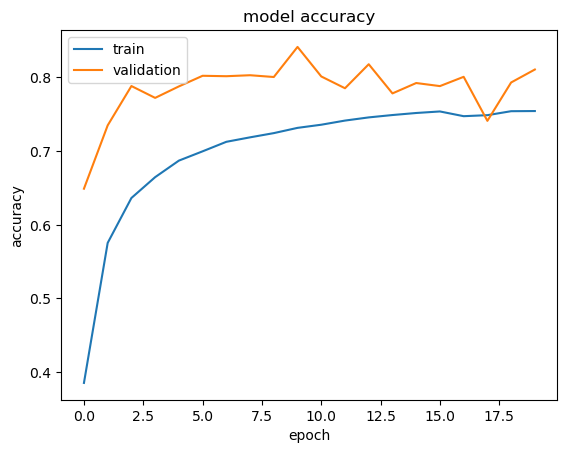

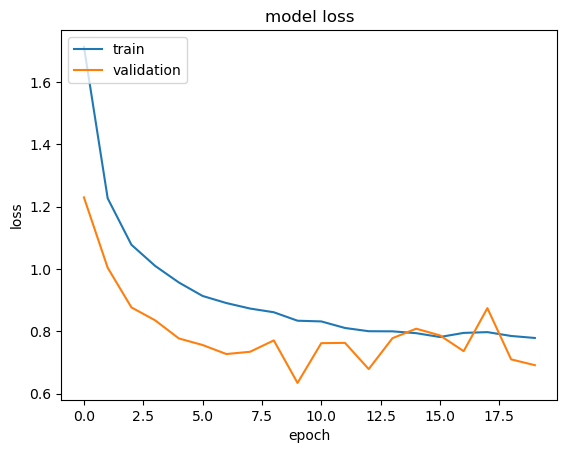

In [203]:
scores = model_cnn.evaluate(test_images, test_labels_oh)
print("Neural network accuracy: %.2f%%" % (scores[1]*100))
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [154]:
y_pred = model_cnn.predict(test_images)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_pred_classes

313/313 [==============================] - 2s 6ms/step


array([7, 2, 1, ..., 4, 3, 6])

<Axes: >

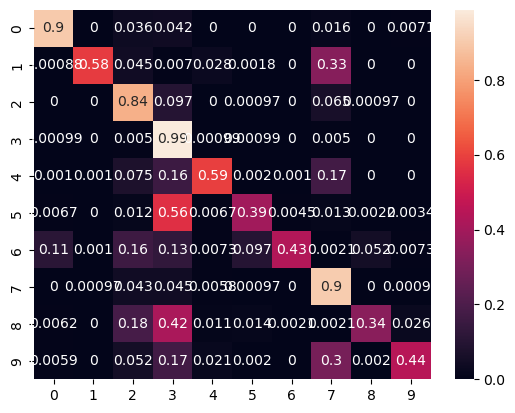

In [155]:
sns.heatmap(sklearn.metrics.confusion_matrix(test_labels, y_pred_classes, normalize="true"), annot=True)

In [159]:
optimizer = RMSprop(learning_rate=0.001)
model_cnn2 = Sequential()
model_cnn2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='normal', input_shape=(28, 28, 1)))
model_cnn2.add(Dropout(.1))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='normal', input_shape=(28, 28, 1)))
model_cnn2.add(Dropout(.1))
model_cnn2.add(Flatten())
model_cnn2.add(Dense(32, activation='relu', kernel_initializer='normal'))
model_cnn2.add(Dropout(.3))
model_cnn2.add(Dense(10, activation='softmax'))
model_cnn2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
model_cnn2.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 dropout_93 (Dropout)        (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 dropout_94 (Dropout)        (None, 11, 11, 32)        0         
                                                                 
 flatten_8 (Flatten)         (None, 3872)              0         
                                                     

In [160]:
history = model_cnn2.fit(train_images, train_labels_oh, validation_split = 0.2, epochs=20, batch_size=130, callbacks = [callback])
scores = model_cnn2.evaluate(test_images_flat, test_labels_oh)
print("Neural network accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
370/370 [==============================] - 44s 116ms/step - loss: 1.7860 - accuracy: 0.3657 - val_loss: 1.2739 - val_accuracy: 0.5761
Epoch 2/20
370/370 [==============================] - 36s 96ms/step - loss: 1.2478 - accuracy: 0.5719 - val_loss: 0.9769 - val_accuracy: 0.7072
Epoch 3/20
370/370 [==============================] - 35s 94ms/step - loss: 1.0129 - accuracy: 0.6598 - val_loss: 0.7446 - val_accuracy: 0.7918
Epoch 4/20
370/370 [==============================] - 35s 96ms/step - loss: 0.8521 - accuracy: 0.7191 - val_loss: 0.6647 - val_accuracy: 0.7955
Epoch 5/20
370/370 [==============================] - 37s 100ms/step - loss: 0.7438 - accuracy: 0.7579 - val_loss: 0.6109 - val_accuracy: 0.8065
Epoch 6/20
370/370 [==============================] - 37s 101ms/step - loss: 0.6650 - accuracy: 0.7843 - val_loss: 0.4348 - val_accuracy: 0.8829
Epoch 7/20
370/370 [==============================] - 38s 102ms/step - loss: 0.6078 - accuracy: 0.8058 - val_loss: 0.4173 - val_accur

313/313 [==============================] - 2s 7ms/step - loss: 89.5815 - accuracy: 0.8003
Neural network accuracy: 80.03%
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


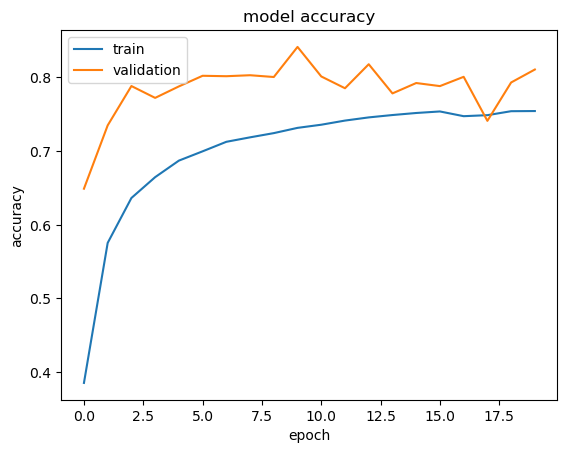

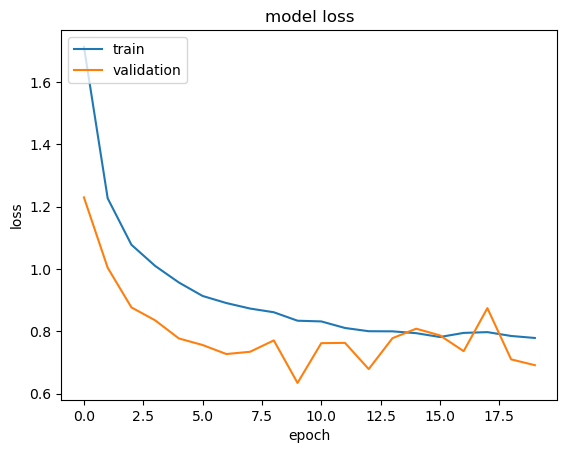

In [208]:
scores = model_cnn2.evaluate(test_images, test_labels_oh)
print("Neural network accuracy: %.2f%%" % (scores[1]*100))
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [163]:
y_pred = model_cnn2.predict(test_images)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_pred_classes

313/313 [==============================] - 1s 4ms/step


array([7, 2, 1, ..., 4, 4, 6])

<Axes: >

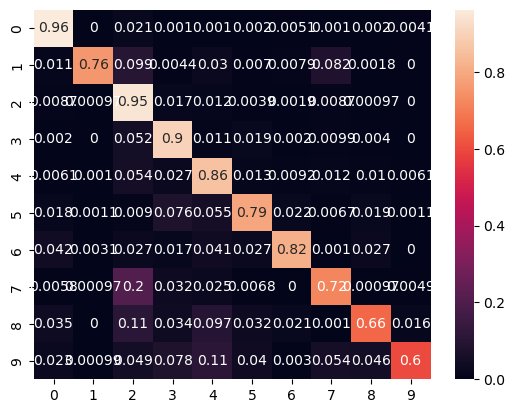

In [164]:
sns.heatmap(sklearn.metrics.confusion_matrix(test_labels, y_pred_classes, normalize="true"), annot=True)